In [39]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as go
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn.functional as F
from torch.nn.functional import cross_entropy
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

In [2]:
from datasets import load_dataset

orignal_ds_from_hf = load_dataset('poem_sentiment')

orignal_ds_from_hf

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label'],
        num_rows: 104
    })
})

In [3]:
train_ds = orignal_ds_from_hf['train']
print(train_ds[0])

{'id': 0, 'verse_text': 'with pale blue berries. in these peaceful shades--', 'label': 1}


In [4]:
print(train_ds.features)
label_names = orignal_ds_from_hf['train'].features['label'].names
label_names

{'id': Value(dtype='int32', id=None), 'verse_text': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'positive', 'no_impact', 'mixed'], id=None)}


['negative', 'positive', 'no_impact', 'mixed']

In [5]:
train_ds['verse_text'][:2]

['with pale blue berries. in these peaceful shades--',
 'it flows so long as falls the rain,']

In [6]:
train = pd.DataFrame(orignal_ds_from_hf['train'])
train.head()

,id,verse_text,label
0,0,with pale blue berries. in these peaceful shad...,1
1,1,"it flows so long as falls the rain,",2
2,2,"and that is why, the lonesome day,",0
3,3,"when i peruse the conquered fame of heroes, an...",3
4,4,of inward strife for truth and liberty.,3


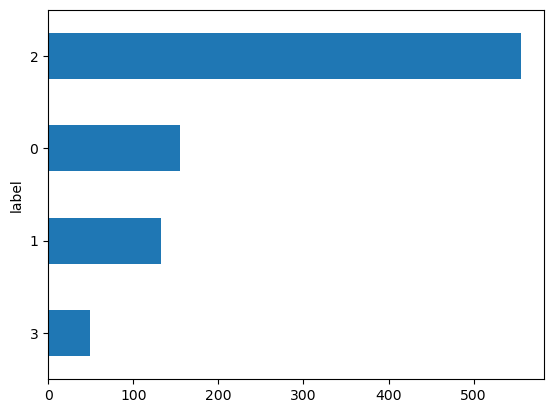

In [7]:
train['label'].value_counts(ascending=True).plot.barh()
plt.show()

## tokenization

In [8]:
model_ckpt = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [9]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [10]:
def tokenize(batch):
    return tokenizer(batch['verse_text'], padding=True, truncation=True)

In [11]:
print(tokenize(orignal_ds_from_hf['train'][:2]))

{'input_ids': [[101, 2007, 5122, 2630, 22681, 1012, 1999, 2122, 9379, 13178, 1011, 1011, 102], [101, 2009, 6223, 2061, 2146, 2004, 4212, 1996, 4542, 1010, 102, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]]}


In [12]:
pretrained_ds_features_encoded = orignal_ds_from_hf.map(tokenize, batched=True, batch_size=None)

print(pretrained_ds_features_encoded['train'].column_names)
print(pretrained_ds_features_encoded)


['id', 'verse_text', 'label', 'input_ids', 'attention_mask']
DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 104
    })
})


In [13]:
df = pd.DataFrame(pretrained_ds_features_encoded['train'])
df.head()

,id,verse_text,label,input_ids,attention_mask
0,0,with pale blue berries. in these peaceful shad...,1,"[101, 2007, 5122, 2630, 22681, 1012, 1999, 212...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
1,1,"it flows so long as falls the rain,",2,"[101, 2009, 6223, 2061, 2146, 2004, 4212, 1996...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
2,2,"and that is why, the lonesome day,",0,"[101, 1998, 2008, 2003, 2339, 1010, 1996, 1045...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,3,"when i peruse the conquered fame of heroes, an...",3,"[101, 2043, 1045, 7304, 3366, 1996, 11438, 447...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,of inward strife for truth and liberty.,3,"[101, 1997, 20546, 27865, 2005, 3606, 1998, 70...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


## training a text classifier - DistilBERT

**token encoding > token embedding > encoded stack > hidden states > classification head > predictions**

In [14]:
model_ckpt = 'distilbert-base-uncased'
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

In [15]:
def get_hidden_state(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state':last_hidden_state[:, 0].cpu().numpy()}

pretrained_ds_features_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
pretrained_hidden_states = pretrained_ds_features_encoded.map(get_hidden_state, batched=True)
pretrained_hidden_states['train'].column_names

['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [16]:
pretrained_hidden_states

DatasetDict({
    train: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 892
    })
    validation: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 105
    })
    test: Dataset({
        features: ['id', 'verse_text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 104
    })
})

In [17]:
X_train = np.array(pretrained_hidden_states['train']['hidden_state'])
X_valid = np.array(pretrained_hidden_states['validation']['hidden_state'])

y_train = np.array(pretrained_hidden_states['train']['label'])
y_valid = np.array(pretrained_hidden_states['validation']['label'])



In [18]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric='cosine').fit(X_train_scaled)

df_embedded_from_hidden = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])

df_embedded_from_hidden['label'] = y_train

display(df_embedded_from_hidden)

,X,Y,label
0,-1.813894,1.767137,1
1,2.550763,0.469718,2
2,1.327814,2.923208,0
3,3.230563,0.274654,3
4,-0.039291,1.286901,3
...,...,...,...
887,-0.421975,2.641957,2
888,1.623694,3.706749,1
889,-0.700719,2.977418,0
890,4.326527,1.638858,2


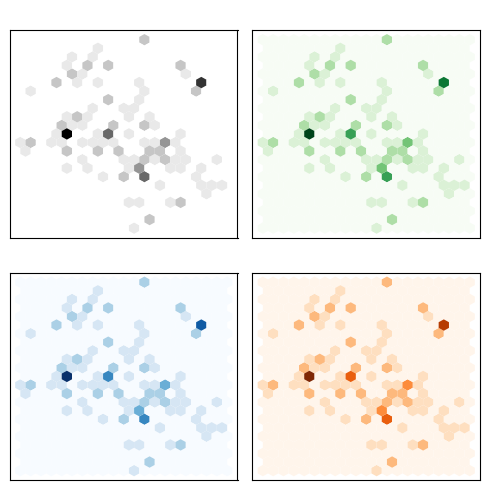

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

axes = axes.flatten()

cmaps = ['Greys', 'Greens', 'Blues', 'Oranges', 'Purples']

labels = orignal_ds_from_hf['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_embedding_subplot = df_embedded_from_hidden.query(f'label == {1}')
    axes[i].hexbin(df_embedding_subplot['X'], df_embedding_subplot['Y'], cmap=cmap,
                   gridsize=20, linewidths=(0, ))
    axes[i].set_title(label, color='white')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [20]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
print(lr_clf.score(X_valid, y_valid))

0.780952380952381


# Dummy classifier

In [21]:
dummy_clf = DummyClassifier(strategy='most_frequent')

dummy_clf.fit(X_train, y_train)
print(dummy_clf.score(X_valid, y_valid))

0.6571428571428571


## fine tunnnign distilBERT

In [31]:
num_labels = len(orignal_ds_from_hf['train'].features['label'].names)
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))

def compute_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy':acc, 'f1':f1}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training




In [33]:
batch_size = 12

logging_steps = len(pretrained_ds_features_encoded['train']) // batch_size
model_name = f'{model_ckpt}-finetune-poem'

training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level='error',
)

In [35]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,
                  train_dataset=pretrained_ds_features_encoded['train'],
                  eval_dataset=pretrained_ds_features_encoded['validation'],
                  tokenizer=tokenizer)

trainer.train()

C:\Users\Ramsaheb Prasad\AppData\Local\Temp\ipykernel_15708\2329765086.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metric,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.042100,0.810842,0.657143,0.521182
2,0.777000,0.648053,0.752381,0.707804


TrainOutput(global_step=150, training_loss=0.9066895151138306, metrics={'train_runtime': 18.3859, 'train_samples_per_second': 97.031, 'train_steps_per_second': 8.158, 'total_flos': 12924311538432.0, 'train_loss': 0.9066895151138306, 'epoch': 2.0})

In [37]:
pred_output = trainer.predict(pretrained_ds_features_encoded['validation'])
pred_output.metrics

{'test_loss': 0.6480528116226196,
 'test_accuracy': 0.7523809523809524,
 'test_f1': 0.7078036601846126,
 'test_runtime': 0.5086,
 'test_samples_per_second': 206.453,
 'test_steps_per_second': 17.696}

## error analysis detect wrong labels by putting the actual and predicted side by side

In [54]:
def forward_pass_with_loss_and_label(batch):
    inputs = {k:v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch['label'].to(device), reduction='none')

    return {'loss': loss.cpu().numpy(), 'predicted_labels': pred_label.cpu().numpy()}

In [55]:
pretrained_ds_features_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
pretrained_ds_features_encoded['validation'] = pretrained_ds_features_encoded['validation'].map(forward_pass_with_loss_and_label, batched=True, batch_size=16)

Map:   0%|          | 0/105 [00:00<?, ? examples/s]

In [57]:
def label_int2str(row):
    return orignal_ds_from_hf['train'].features['label'].int2str(row)

pretrained_ds_features_encoded.set_format('pandas')

cols = ['verse_text', 'label', 'predicted_labels', 'loss']

df_test = pretrained_ds_features_encoded['validation'][:][cols]

df_test['label'] = df_test['label'].apply(label_int2str)

df_test.sort_values('loss', ascending=True).head(10)

,verse_text,label,predicted_labels,loss
54,"might, looking up, see dian dip",no_impact,2,0.128204
39,"soon ez she gits out o' sight,",no_impact,2,0.129752
45,"and i greet from far the ray,",no_impact,2,0.131426
28,"what though the claret circled well,",no_impact,2,0.134309
33,that in their holes abed at close of day,no_impact,2,0.136851
74,"from the bed of minnehaha,",no_impact,2,0.137941
51,ere i own an usurper i'll couch with the fox;,no_impact,2,0.138102
100,"said my companion, 'i will show you soon",no_impact,2,0.138804
37,"why write i still all one, ever the same,",no_impact,2,0.140193
88,and in some deep and narrow bay then sleeps,no_impact,2,0.142423


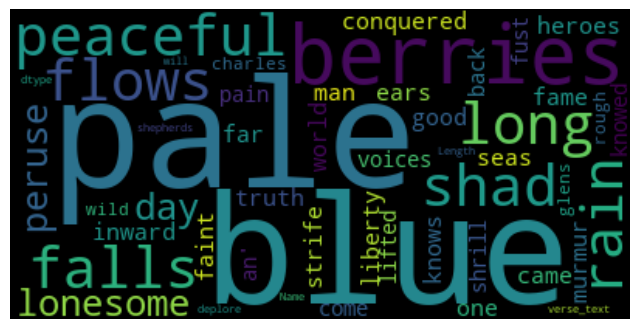

In [62]:
wordcloud = WordCloud(max_words=50, random_state=30, collocations=True).generate(str(train['verse_text']))
plt.figure(figsize=(8, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()